## Experiment for k-means clustering

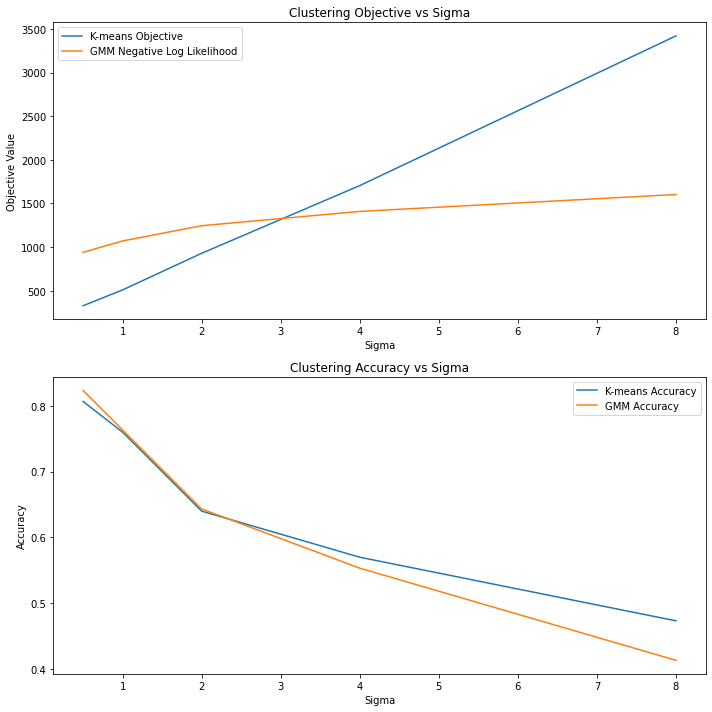

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score

# generate synthetic data
def generate_data(sigma, n=100):
    cov_a = np.array([[2, 0.5], [0.5, 1]]) * sigma
    cov_b = np.array([[1, -0.5], [-0.5, 2]]) * sigma
    cov_c = np.array([[1, 0], [0, 2]]) * sigma
    P_a = np.random.multivariate_normal([-1, -1], cov_a, n)
    P_b = np.random.multivariate_normal([1, -1], cov_b, n)
    P_c = np.random.multivariate_normal([0, 1], cov_c, n)
    return np.vstack((P_a, P_b, P_c)), np.array([0]*n + [1]*n + [2]*n)

# compute the best mapping from cluster ids to true labels
def best_mapping(cluster_ids, true_labels):
    D = np.zeros((3, 3), dtype=int)
    for i in range(3):
        for j in range(3):
            D[i, j] = np.count_nonzero(cluster_ids[true_labels == i] == j)
    row_ind, col_ind = linear_sum_assignment(D, maximize=True)
    return col_ind

# compute clustering accuracy
def clustering_accuracy(cluster_ids, true_labels):
    col_ind = best_mapping(cluster_ids, true_labels)
    mapped_cluster_ids = np.zeros_like(cluster_ids)
    for i in range(3):
        mapped_cluster_ids[cluster_ids == col_ind[i]] = i
    return accuracy_score(true_labels, mapped_cluster_ids)

# k-means and GMM clustering with multiple restarts
def cluster_data(X, n_clusters=3, n_init=10):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init).fit(X)
    gmm = GaussianMixture(n_components=n_clusters, n_init=n_init).fit(X)
    return kmeans, gmm

# evaluate clustering using K-means and GMM
sigmas = [0.5, 1, 2, 4, 8]
kmeans_objectives = []
gmm_objectives = []
kmeans_accuracies = []
gmm_accuracies = []

for sigma in sigmas:
    X, true_labels = generate_data(sigma)
    kmeans, gmm = cluster_data(X)

    # k-means
    kmeans_labels = kmeans.predict(X)
    kmeans_objectives.append(kmeans.inertia_)
    kmeans_accuracies.append(clustering_accuracy(kmeans_labels, true_labels))

    # GMM
    gmm_labels = gmm.predict(X)
    gmm_objectives.append(-gmm.score(X) * len(X))  # Negative log likelihood
    gmm_accuracies.append(clustering_accuracy(gmm_labels, true_labels))

# results plot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# clustering objective plot
axs[0].plot(sigmas, kmeans_objectives, label='K-means Objective')
axs[0].plot(sigmas, gmm_objectives, label='GMM Negative Log Likelihood')
axs[0].set_xlabel('Sigma')
axs[0].set_ylabel('Objective Value')
axs[0].set_title('Clustering Objective vs Sigma')
axs[0].legend()

# clustering accuracy plot
axs[1].plot(sigmas, kmeans_accuracies, label='K-means Accuracy')
axs[1].plot(sigmas, gmm_accuracies, label='GMM Accuracy')
axs[1].set_xlabel('Sigma')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Clustering Accuracy vs Sigma')
axs[1].legend()

plt.tight_layout()
plt.show()


## Experiment for PCA

In [26]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_2D = np.array(pd.read_csv('./data/data2D.csv', header=None, index_col=None))
X_1000D = np.array(pd.read_csv('./data/data1000D.csv', header=None, index_col=None))

In [41]:
# perform Buggy PCA
def buggy_pca(X, d):
    pca = PCA(n_components=d)
    pca.fit(X)
    Z = pca.transform(X)
    X_reconstructed = pca.inverse_transform(Z)
    return Z, pca.components_.T, X_reconstructed

# perform Demeaned PCA
def demeaned_pca(X, d):
    mean = np.mean(X, axis=0)
    X_demeaned = X - mean
    pca = PCA(n_components=d)
    pca.fit(X_demeaned)
    Z = pca.transform(X_demeaned)
    X_reconstructed = pca.inverse_transform(Z) + mean
    return Z, pca.components_.T, X_reconstructed

# perform Normalized PCA
def normalized_pca(X, d):
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    pca = PCA(n_components=d)
    pca.fit(X_normalized)
    Z = pca.transform(X_normalized)
    X_reconstructed = scaler.inverse_transform(pca.inverse_transform(Z))
    return Z, pca.components_.T, X_reconstructed

# perform DRO
def dro(X, d):
    mean = np.mean(X, axis=0)
    X_demeaned = X - mean
    pca = PCA(n_components=d)
    pca.fit(X_demeaned)
    Z = pca.transform(X_demeaned)
    A = pca.components_.T
    b = mean - np.dot(A, np.dot(A.T, mean))
    X_reconstructed = np.dot(Z, A.T) + b
    return Z, A, b, X_reconstructed


In [44]:
# Perform each method on the 2D data
Z_buggy_2D, A_buggy_2D, X_rec_buggy_2D = buggy_pca(X_2D, d=1)
Z_demeaned_2D, A_demeaned_2D, X_rec_demeaned_2D = demeaned_pca(X_2D, d=1)
Z_normalized_2D, A_normalized_2D, X_rec_normalized_2D = normalized_pca(X_2D, d=1)
Z_dro_2D, A_dro_2D, b_dro_2D, X_rec_dro_2D = dro(X_2D, d=1)

# Calculate reconstruction error for 2D data
error_buggy_2D = np.sum((X_2D - X_rec_buggy_2D) ** 2)/X_2D.shape[0]
error_demeaned_2D = np.sum((X_2D - X_rec_demeaned_2D) ** 2)/X_2D.shape[0]
error_normalized_2D = np.sum((X_2D - X_rec_normalized_2D) ** 2)/X_2D.shape[0]
error_dro_2D = np.sum((X_2D - X_rec_dro_2D) ** 2)/X_2D.shape[0]

error_buggy_2D, error_demeaned_2D, error_normalized_2D, error_dro_2D


(0.010006085628512906,
 0.010006085628512917,
 0.0494720834547707,
 21.651457821116438)

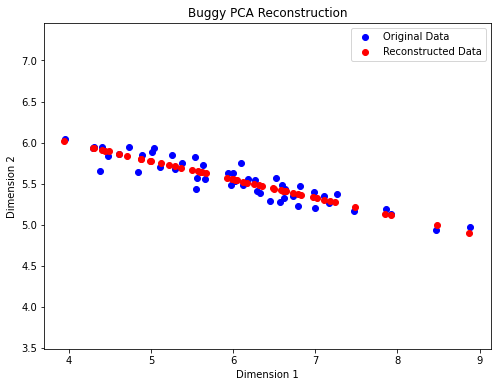

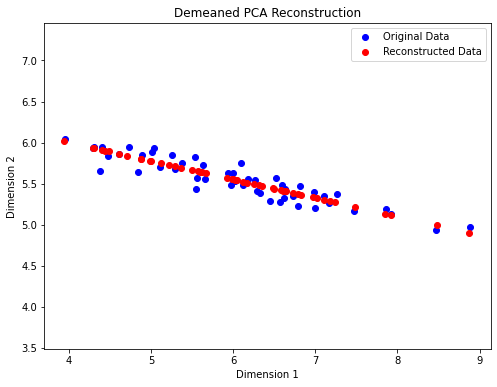

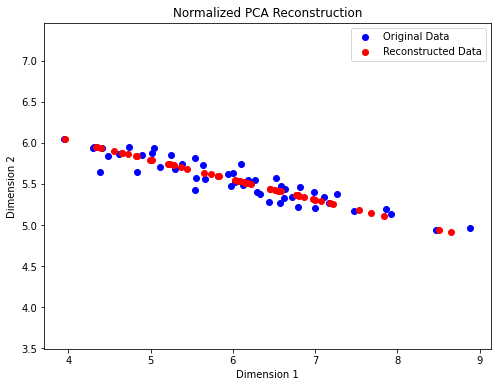

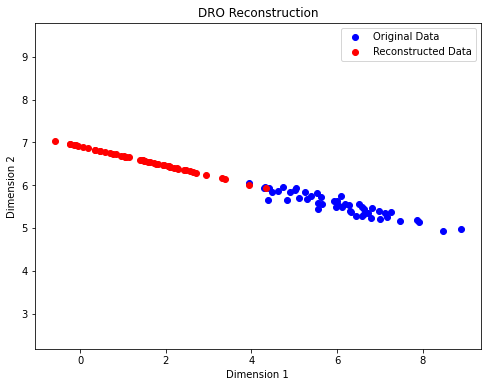

In [39]:
import matplotlib.pyplot as plt

# Plotting function to compare original points with the reconstructed points
def plot_reconstructions(X_original, X_reconstructed, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_original[:, 0], X_original[:, 1], c='blue', label='Original Data')
    plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], c='red', label='Reconstructed Data')
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Plot the reconstructions for each PCA variant and DRO
plot_reconstructions(X_2D, X_rec_buggy_2D, 'Buggy PCA Reconstruction')
plot_reconstructions(X_2D, X_rec_demeaned_2D, 'Demeaned PCA Reconstruction')
plot_reconstructions(X_2D, X_rec_normalized_2D, 'Normalized PCA Reconstruction')
plot_reconstructions(X_2D, X_rec_dro_2D, 'DRO Reconstruction')


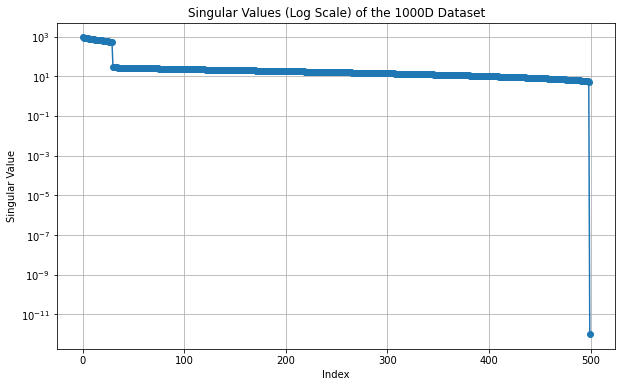

In [40]:
# Perform DRO on the 1000D data to observe the singular values
_, _, _, X_rec_dro_1000D = dro(X_1000D, d=min(X_1000D.shape))

# Compute PCA to obtain the singular values
pca_1000D = PCA()
pca_1000D.fit(X_1000D)

# Plot the spectrum of singular values
plt.figure(figsize=(10, 6))
plt.plot(pca_1000D.singular_values_, marker='o')
plt.yscale('log')
plt.title('Singular Values (Log Scale) of the 1000D Dataset')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()


In [45]:
estimated_d = 50

# Perform each method on the actual 1000D data with the estimated 'd'
Z_buggy_1000D, A_buggy_1000D, X_rec_buggy_1000D = buggy_pca(X_1000D, d=estimated_d)
Z_demeaned_1000D, A_demeaned_1000D, X_rec_demeaned_1000D = demeaned_pca(X_1000D, d=estimated_d)
Z_normalized_1000D, A_normalized_1000D, X_rec_normalized_1000D = normalized_pca(X_1000D, d=estimated_d)
Z_dro_1000D, A_dro_1000D, b_dro_1000D, X_rec_dro_1000D = dro(X_1000D, d=estimated_d)

# Calculate reconstruction error for actual 1000D data
error_buggy_1000D = np.sum((X_1000D - X_rec_buggy_1000D) ** 2)/X_1000D.shape[0]
error_demeaned_1000D = np.sum((X_1000D - X_rec_demeaned_1000D) ** 2)/X_1000D.shape[0]
error_normalized_1000D = np.sum((X_1000D - X_rec_normalized_1000D) ** 2)/X_1000D.shape[0]
error_dro_1000D = np.sum((X_1000D - X_rec_dro_1000D) ** 2)/X_1000D.shape[0]

# Output the errors for the 1000D dataset
error_buggy_1000D, error_demeaned_1000D, error_normalized_1000D, error_dro_1000D


(244.49020134327372,
 244.58299311912438,
 246.05270189785438,
 27203.779459180918)